## Finding Relative Value Trades on the Treasury Yield Curve using PCA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set_theme(style="whitegrid", palette="deep")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.options.display.float_format = '{:.4f}'.format

## Getting & Cleaning Data

In [2]:
weblink = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value='

In [3]:
yrs = range(2010, 2022+1)
rates = pd.DataFrame()

for i in yrs:
    link = weblink + str(i)
    webpage = pd.read_html(link)
    rates = rates.append(webpage[0])

In [4]:
rates.head()

,Date,20 YR,30 YR,Extrapolation Factor,8 WEEKS BANK DISCOUNT,COUPON EQUIVALENT,52 WEEKS BANK DISCOUNT,COUPON EQUIVALENT.1,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,01/04/2010,nan,nan,nan,nan,nan,nan,nan,0.0500,nan,0.0800,0.1800,0.4500,1.0900,1.6600,2.6500,3.3600,3.8500,4.6000,4.6500
1,01/05/2010,nan,nan,nan,nan,nan,nan,nan,0.0300,nan,0.0700,0.1700,0.4100,1.0100,1.5700,2.5600,3.2800,3.7700,4.5400,4.5900
2,01/06/2010,nan,nan,nan,nan,nan,nan,nan,0.0300,nan,0.0600,0.1500,0.4000,1.0100,1.6000,2.6000,3.3300,3.8500,4.6300,4.7000
3,01/07/2010,nan,nan,nan,nan,nan,nan,nan,0.0200,nan,0.0500,0.1600,0.4000,1.0300,1.6200,2.6200,3.3300,3.8500,4.6200,4.6900
4,01/08/2010,nan,nan,nan,nan,nan,nan,nan,0.0200,nan,0.0500,0.1500,0.3700,0.9600,1.5600,2.5700,3.3100,3.8300,4.6100,4.7000


In [5]:
rates = rates[['Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']]
rates['Date'] = pd.to_datetime(rates['Date'])
rates = rates.set_index('Date')
rates.columns = ['1mo', '3mo', '6mo', '1yr', '2yr', '3yr', '5yr', '7yr', '10yr', '20yr', '30yr']

rates.head()

,1mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
Date,,,,,,,,,,,
2010-01-04,0.0500,0.0800,0.1800,0.4500,1.0900,1.6600,2.6500,3.3600,3.8500,4.6000,4.6500
2010-01-05,0.0300,0.0700,0.1700,0.4100,1.0100,1.5700,2.5600,3.2800,3.7700,4.5400,4.5900
2010-01-06,0.0300,0.0600,0.1500,0.4000,1.0100,1.6000,2.6000,3.3300,3.8500,4.6300,4.7000
2010-01-07,0.0200,0.0500,0.1600,0.4000,1.0300,1.6200,2.6200,3.3300,3.8500,4.6200,4.6900
2010-01-08,0.0200,0.0500,0.1500,0.3700,0.9600,1.5600,2.5700,3.3100,3.8300,4.6100,4.7000


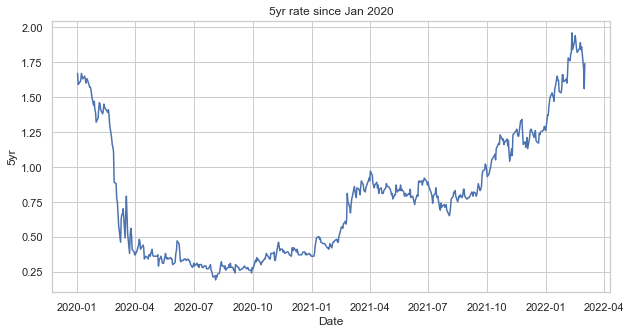

In [6]:
plt.figure(figsize=(10,5))

sns.lineplot(x=rates.query("Date>='1 Jan 2020'").index, y=rates.query("Date>='1 Jan 2020'")['5yr']).\
set_title('5yr rate since Jan 2020');

In [7]:
n_term_point = rates.shape[1]
n_term_point

11

In [8]:
pd.DataFrame({'mean':rates.mean(), 'std':rates.std()}).T

,1mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
mean,0.4761,0.5096,0.5783,0.6608,0.8595,1.0652,1.4928,1.8634,2.1933,2.7054,2.9474
std,0.7369,0.7519,0.7678,0.7726,0.7349,0.7007,0.6618,0.6654,0.7003,0.7642,0.7769


In [9]:
rates.isna().sum()

1mo     1
3mo     1
6mo     1
1yr     1
2yr     1
3yr     1
5yr     1
7yr     1
10yr    1
20yr    1
30yr    1
dtype: int64

In [10]:
print('before removing missing values: ', rates.shape)
rates = rates.dropna()
print('after removing missing values: ', rates.shape)

before removing missing values:  (3045, 11)
after removing missing values:  (3044, 11)


In [11]:
# rates.to_csv('PCAdata.csv')

## PCA Modeling

### Scaling data

In [12]:
sc = StandardScaler()
rates_sc = sc.fit_transform(rates)
rates_sc = pd.DataFrame(rates_sc, columns=rates.columns, index=rates.index)
rates_sc.head()

,1mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
Date,,,,,,,,,,,
2010-01-04,-0.5784,-0.5714,-0.5189,-0.2729,0.3137,0.8490,1.7487,2.2495,2.3661,2.4796,2.1919
2010-01-05,-0.6055,-0.5847,-0.5319,-0.3247,0.2049,0.7205,1.6127,2.1293,2.2519,2.4011,2.1146
2010-01-06,-0.6055,-0.5980,-0.5580,-0.3376,0.2049,0.7633,1.6731,2.2045,2.3661,2.5189,2.2563
2010-01-07,-0.6191,-0.6113,-0.5449,-0.3376,0.2321,0.7919,1.7034,2.2045,2.3661,2.5058,2.2434
2010-01-08,-0.6191,-0.6113,-0.5580,-0.3765,0.1368,0.7062,1.6278,2.1744,2.3375,2.4927,2.2563


In [13]:
# Scaled data with Mean=0 and Std=1
pd.DataFrame({'mean':rates_sc.mean(), 'std':rates_sc.std()}).T

,1mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
mean,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000
std,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002


### Running PCA - 
* **3 principal components capture most of the information**
* These 3 PCs are popularly interpreted as (1) Level, (2) Slope and (3) Curvature of the yield curve, considering their loadings

In [14]:
pca_model = PCA()
pca_model.fit(rates_sc)

pc_names = ['PC'+str(i) for i in range(1,n_term_point+1)]

In [15]:
pct_exp = pd.Series(pca_model.explained_variance_ratio_*100, index=pc_names)
pct_exp

PC1    65.0202
PC2    32.1045
PC3     2.4746
PC4     0.2801
PC5     0.0533
PC6     0.0370
PC7     0.0124
PC8     0.0080
PC9     0.0041
PC10    0.0036
PC11    0.0023
dtype: float64

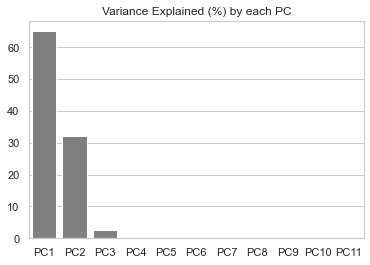

In [16]:
sns.barplot(x=pct_exp.index, y=pct_exp.values, color='grey').\
set_title('Variance Explained (%) by each PC');

In [17]:
loadings = pd.DataFrame(pca_model.components_.T.round(4))
loadings.index = rates.columns
loadings.columns = pc_names
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
1mo,0.3196,-0.2497,-0.3890,-0.4734,-0.1990,0.4094,0.4023,0.2492,-0.1513,-0.0765,0.0125
3mo,0.3250,-0.2460,-0.3244,-0.2274,0.0615,-0.0861,-0.4025,-0.3700,0.4219,0.4322,-0.0436
6mo,0.3312,-0.2386,-0.2211,0.0904,0.0365,-0.3719,-0.2968,-0.0720,-0.2235,-0.6882,0.1408
1yr,0.3399,-0.2170,-0.0758,0.4019,0.1469,-0.3901,0.2584,0.3127,-0.2683,0.4177,-0.2922
2yr,0.3573,-0.1409,0.1875,0.4568,0.0870,0.2693,0.2423,0.0226,0.4489,-0.0681,0.5130
3yr,0.3647,-0.0465,0.3781,0.1643,-0.0905,0.4666,-0.1764,-0.2681,-0.1502,-0.1293,-0.5716
5yr,0.3459,0.1624,0.4227,-0.2653,-0.1571,-0.0427,-0.3168,0.1608,-0.3921,0.2955,0.4594
7yr,0.3010,0.3041,0.2781,-0.3324,-0.0230,-0.3366,0.1081,0.3369,0.5076,-0.2190,-0.2905
10yr,0.2382,0.4096,-0.0362,-0.1019,0.1142,-0.1947,0.4999,-0.6508,-0.1794,0.0101,0.0843
20yr,0.1518,0.4778,-0.3074,0.0422,0.6685,0.3009,-0.2270,0.2388,-0.0756,-0.0203,-0.0109


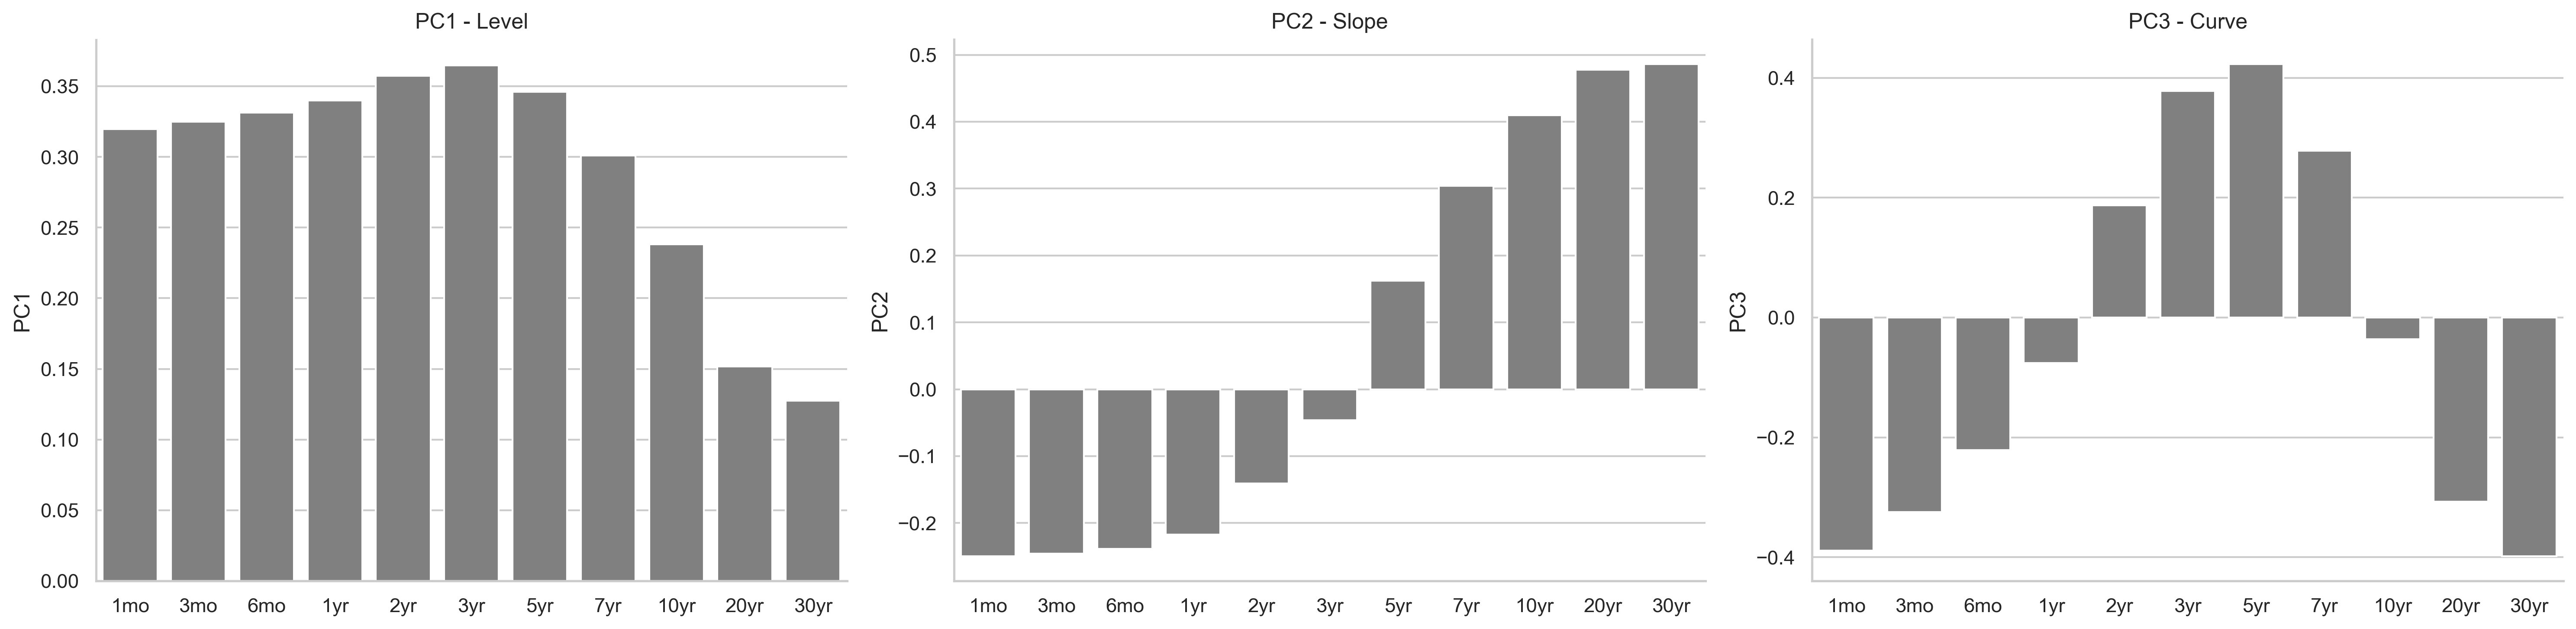

In [18]:
plt.figure(figsize=(20,5), dpi=300)
plt.subplot(1,3,1)
sns.barplot(x=loadings.index, y=loadings['PC1'], color='grey', label='PC1').set_title('PC1 - Level');
plt.subplot(1,3,2)
sns.barplot(x=loadings.index, y=loadings['PC2'], color='grey', label='PC2').set_title('PC2 - Slope');
plt.subplot(1,3,3)
sns.barplot(x=loadings.index, y=loadings['PC3'], color='grey', label='PC3').set_title('PC3 - Curve');
plt.tight_layout()
sns.despine()

## Reconstructing Data using fewer PCAs

In [19]:
# Number of PCs to be used
nPC = 3

In [20]:
# Calculating PCA Scores
scores = np.matmul(rates_sc, loadings)
scores.columns = loadings.columns

print(scores.shape)
scores.head()

(3044, 11)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Date,,,,,,,,,,,
2010-01-04,2.2882,4.5714,0.5690,-0.0407,0.1309,0.1026,0.0229,0.0550,0.0267,0.0073,-0.0103
2010-01-05,2.0353,4.4366,0.4898,-0.0607,0.1390,0.0713,0.0053,0.0573,0.0264,-0.0020,-0.0144
2010-01-06,2.1403,4.6514,0.4667,-0.0557,0.1189,0.0961,0.0078,0.0480,0.0173,0.0059,-0.0260
2010-01-07,2.1629,4.6422,0.5113,-0.0410,0.1160,0.1020,0.0005,0.0423,0.0072,-0.0047,-0.0119
2010-01-08,2.0378,4.6381,0.4265,-0.0785,0.1013,0.0717,-0.0059,0.0461,0.0119,-0.0096,-0.0307


In [21]:
# Separating scores for top PCs
scores_pc = scores.loc[:, scores.columns[0:nPC]]

print(scores_pc.shape)
scores_pc.head()

(3044, 3)


,PC1,PC2,PC3
Date,,,
2010-01-04,2.2882,4.5714,0.5690
2010-01-05,2.0353,4.4366,0.4898
2010-01-06,2.1403,4.6514,0.4667
2010-01-07,2.1629,4.6422,0.5113
2010-01-08,2.0378,4.6381,0.4265


In [22]:
# Inverse of Loadings - separated for top PCs
loadings_inv = np.linalg.inv(loadings)

loadings_inv_pc= pd.DataFrame(loadings_inv[0:nPC])
loadings_inv_pc.index   = scores_pc.columns
loadings_inv_pc.columns = loadings.index

print(loadings_inv_pc.shape)
loadings_inv_pc.head()

(3, 11)


,1mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
PC1,0.3196,0.3250,0.3312,0.3398,0.3574,0.3647,0.3459,0.3011,0.2382,0.1518,0.1276
PC2,-0.2498,-0.2460,-0.2386,-0.2170,-0.1409,-0.0464,0.1624,0.3041,0.4096,0.4779,0.4860
PC3,-0.3890,-0.3244,-0.2211,-0.0758,0.1875,0.3782,0.4228,0.2781,-0.0362,-0.3075,-0.3985


In [23]:
# Reconstructing 'scaled' data
# Matrix multiplication with Pandas Dataframes throws error even when dimensions are proper
rates_pca_sc = pd.DataFrame(np.matmul(scores_pc.to_numpy(), loadings_inv_pc.to_numpy()), 
                            columns=loadings_inv_pc.columns, index=scores_pc.index)

print(rates_pca_sc.shape)
rates_pca_sc.head()

(3044, 11)


,1mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
Date,,,,,,,,,,,
2010-01-04,-0.6318,-0.5652,-0.4586,-0.2578,0.2803,0.8375,1.7743,2.2376,2.3969,2.3571,2.2867
2010-01-05,-0.6481,-0.5886,-0.4927,-0.3084,0.1941,0.7216,1.6315,2.0984,2.2843,2.2786,2.2204
2010-01-06,-0.6593,-0.5998,-0.5041,-0.3177,0.1970,0.7411,1.6929,2.1890,2.3981,2.4043,2.3474
2010-01-07,-0.6671,-0.6046,-0.5043,-0.3114,0.2147,0.7667,1.7181,2.2054,2.3981,2.3896,2.3281
2010-01-08,-0.6730,-0.6168,-0.5260,-0.3465,0.1547,0.6891,1.6383,2.1428,2.3697,2.3947,2.3439


In [24]:
# Descaling data
rates_pca = pd.DataFrame(sc.inverse_transform(rates_pca_sc),
                         columns=rates_pca_sc.columns, index=rates_pca_sc.index)

print(rates_pca.shape)
rates_pca.head()

(3044, 11)


,1mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
Date,,,,,,,,,,,
2010-01-04,0.0106,0.0847,0.2263,0.4617,1.0655,1.6519,2.6670,3.3521,3.8715,4.5063,4.7236
2010-01-05,-0.0014,0.0671,0.2001,0.4225,1.0021,1.5707,2.5724,3.2595,3.7927,4.4464,4.6722
2010-01-06,-0.0096,0.0587,0.1913,0.4154,1.0042,1.5845,2.6131,3.3197,3.8724,4.5424,4.7708
2010-01-07,-0.0154,0.0550,0.1912,0.4203,1.0173,1.6023,2.6297,3.3306,3.8724,4.5312,4.7558
2010-01-08,-0.0198,0.0459,0.1746,0.3931,0.9732,1.5480,2.5769,3.2890,3.8525,4.5351,4.7681


## Relative Value assessment

In [25]:
# Term point of interest
term = '10yr'

In [26]:
relative_value = pd.DataFrame(pd.concat([rates[term], rates_pca[term], rates[term]-rates_pca[term]], axis=1))
relative_value.columns = ['Actual', 'PCA', 'Diff']
relative_value['Cheap'] = (relative_value['Diff'] > 0)
relative_value.head()

,Actual,PCA,Diff,Cheap
Date,,,,
2010-01-04,3.8500,3.8715,-0.0215,False
2010-01-05,3.7700,3.7927,-0.0227,False
2010-01-06,3.8500,3.8724,-0.0224,False
2010-01-07,3.8500,3.8724,-0.0224,False
2010-01-08,3.8300,3.8525,-0.0225,False


In [27]:
relative_value['Cheap'].value_counts()

False    1582
True     1462
Name: Cheap, dtype: int64

### Long Term Trend
* any particular term point on the yield curve goes through cycles of 'richness'/'cheapness'

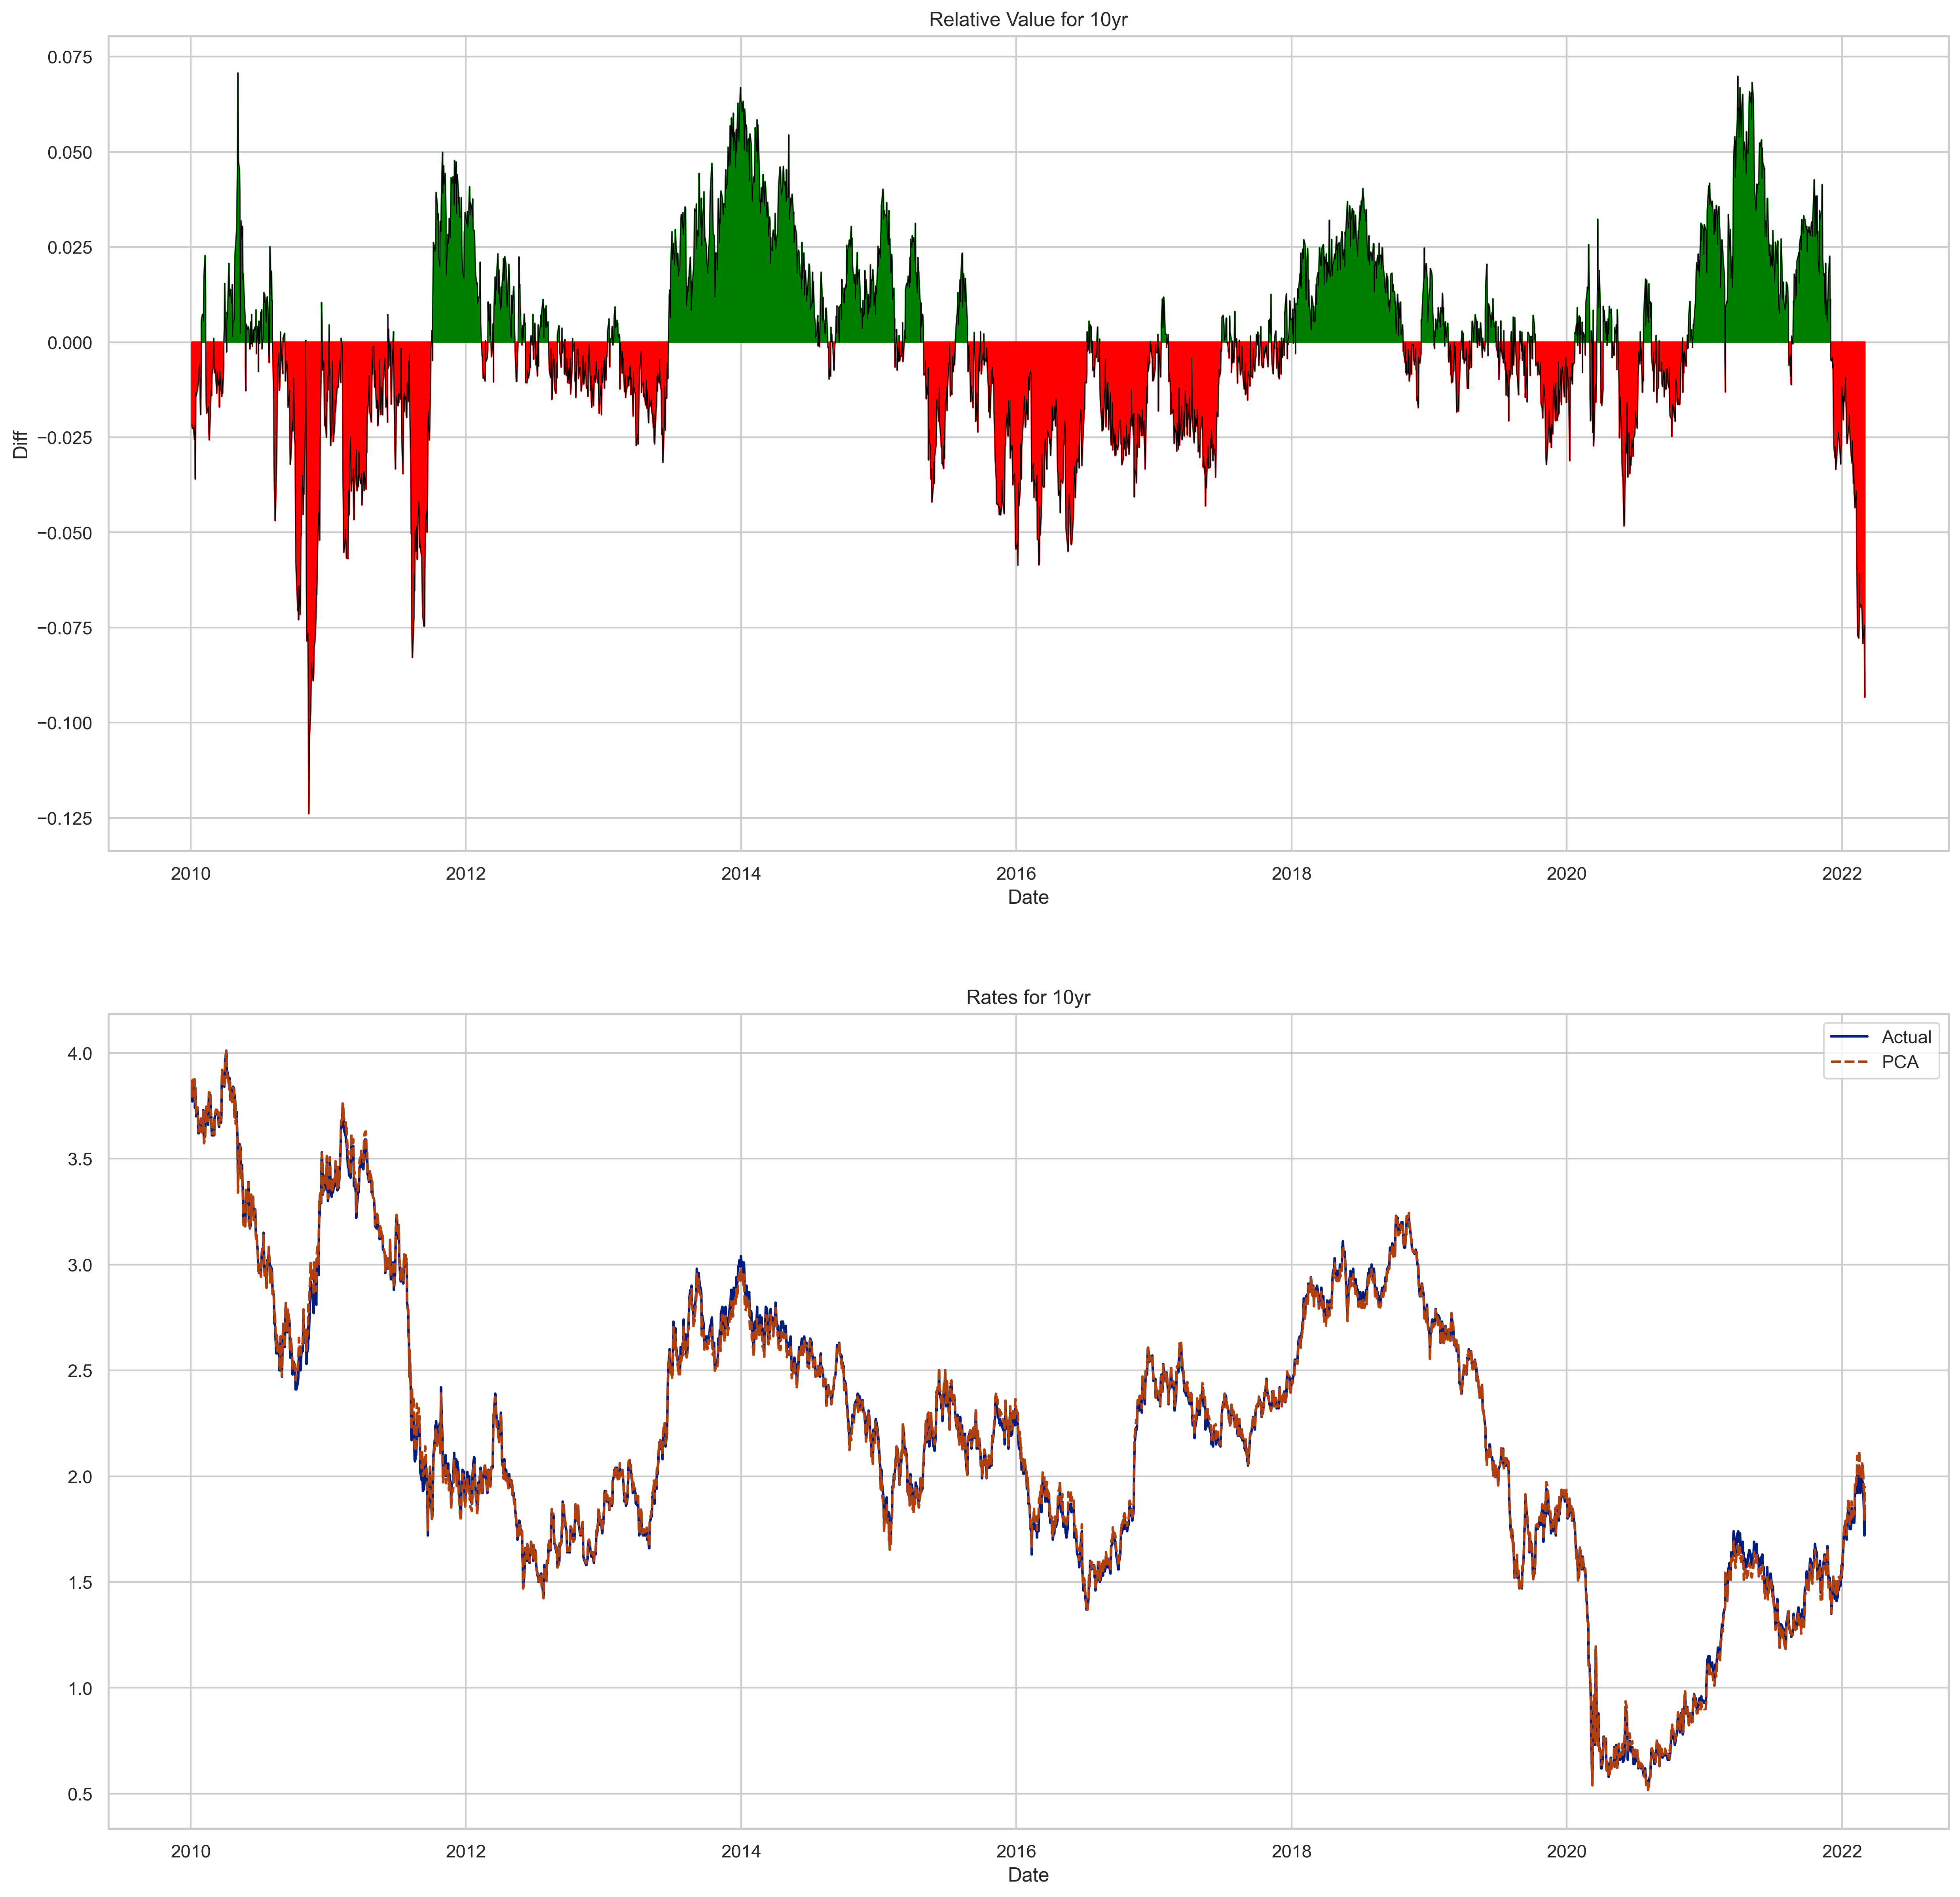

In [28]:
# Plotting Long Term Trend
plt.figure(figsize=(20,20), dpi=300)

plt.subplot(2,1,1)
sns.lineplot(data=relative_value['Diff'], color='black', linewidth=.5).set_title('Relative Value for {}'.format(term));
plt.fill_between(relative_value.index, 0, relative_value['Diff'], where=relative_value['Cheap'], color='green')
plt.fill_between(relative_value.index, 0, relative_value['Diff'], where=(~relative_value['Cheap']), color='red')

plt.subplot(2,1,2)
sns.lineplot(data=relative_value[['Actual', 'PCA']], palette='dark').set_title('Rates for {}'.format(term));


### Last 3 month Trend - for a particular term point

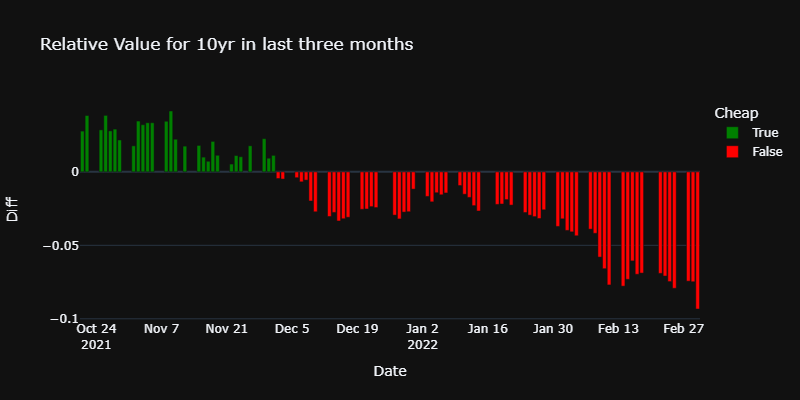

In [29]:
fig = px.bar(data_frame=relative_value[-90:], y='Diff', color='Cheap', template='plotly_dark',
             color_discrete_sequence=["green", "red"], 
             width = 800, height=400,
             title='Relative Value for {} in last three months'.format(term))
fig.show("png")

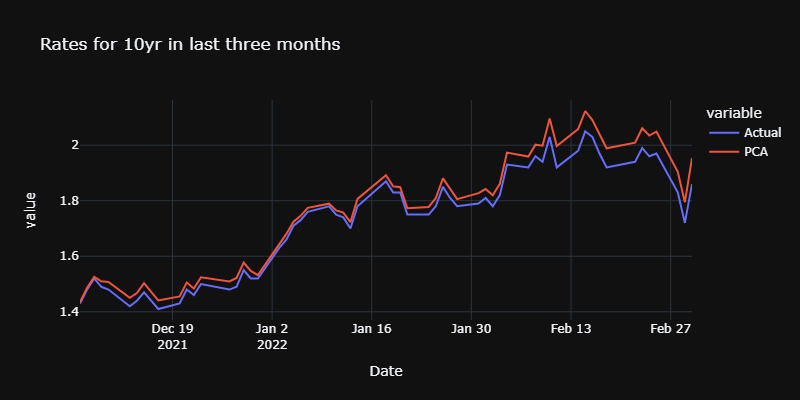

In [30]:
fig = px.line(data_frame=relative_value[-60:], y=['Actual', 'PCA'], template='plotly_dark',
              width = 800, height=400,
              title='Rates for {} in last three months'.format(term))
fig.show("png")

### Relative Value across the Yield Curve

In [31]:
last_week = rates[-5:] - rates_pca[-5:]
last_week = last_week.stack().reset_index()
last_week.columns =['Date', 'Term', 'RelativeValue']
last_week = last_week.set_index('Date')
last_week['Cheap'] = (last_week['RelativeValue'] >0)
# last_week.head()

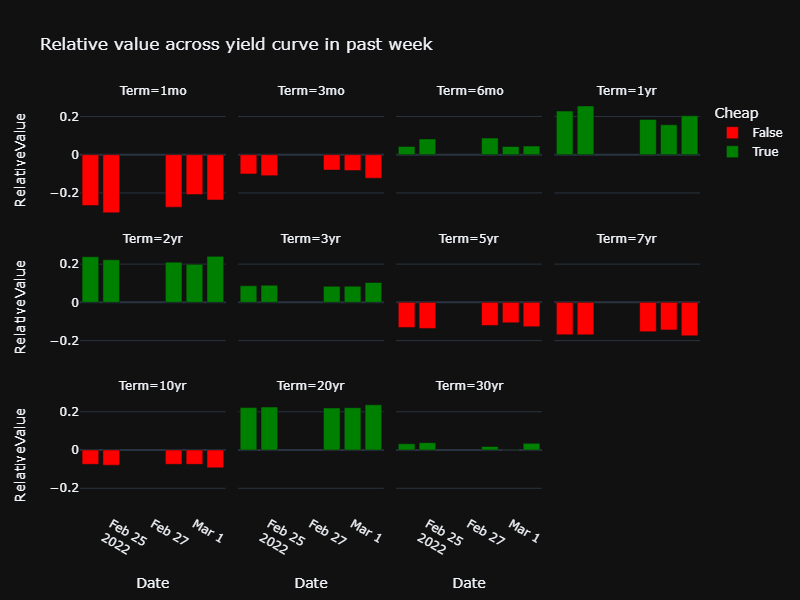

In [32]:
fig = px.bar(data_frame=last_week, y='RelativeValue', template='plotly_dark', color='Cheap',
             facet_col='Term', facet_col_wrap=4, 
             color_discrete_sequence={False: 'red', True: 'green'},
             title = 'Relative value across yield curve in past week',
             width = 800, height=600)
# fig.show("svg")
fig.show('png')